# DYNAMIC MEV PREDICTION

The Flashbots data used has been collected by running an MEV-Geth node, querying the public [mev-blocks API]
(https://blocks.flashbots.net) and looking at data in the [public dashboard](https://dashboard.flashbots.net) of Flashbots activity.

### PREDICTING MEV AS A CLASS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import miner REV data from file, from Mined Bundles table of the mev Metabase dataset
data = pd.read_csv('/Users/macbook/Downloads/miner-REV.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101916 entries, 0 to 101915
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Block Number      101916 non-null  int64  
 1   Eo A              101916 non-null  object 
 2   Contract          101898 non-null  object 
 3   Gas Used          101916 non-null  int64  
 4   Gas Price         101916 non-null  int64  
 5   Miner Reward      101916 non-null  object 
 6   Tx Count          101916 non-null  int64  
 7   Miner             101916 non-null  object 
 8   Transaction Hash  101916 non-null  object 
 9   Relay Bundle ID   100040 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 7.8+ MB


In [5]:
data['Miner Reward'] = data['Miner Reward'].astype(float)
data['MEV'] = data['Miner Reward']/1000000000000000000

In [6]:
# splitting MEV values into different clusters
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
pred = km.fit_predict(data[['Block Number','MEV']])

In [7]:
data['MEV_cluster'] = pred

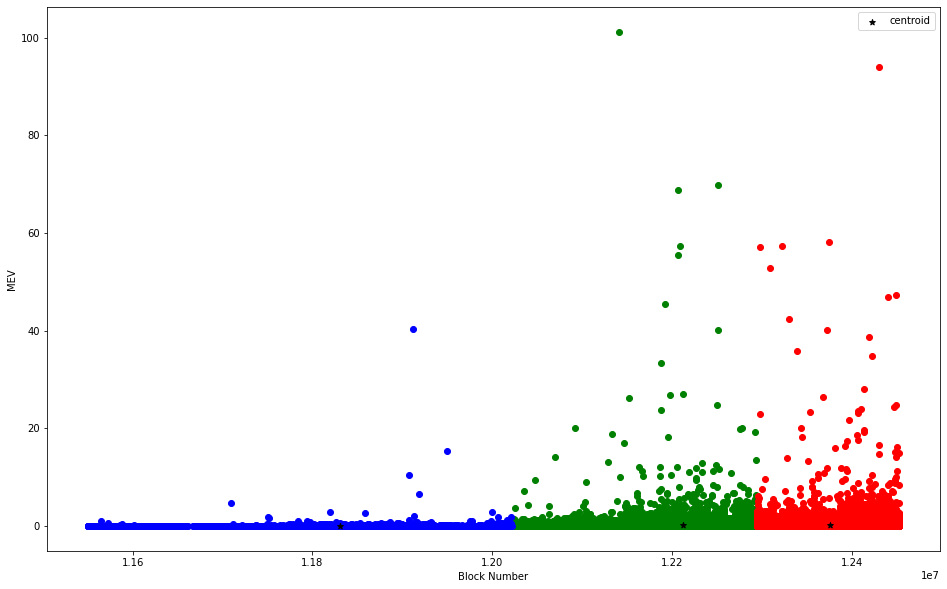

In [8]:
# visualizing MEV clusters

df1 = data[data.MEV_cluster==0]
df2 = data[data.MEV_cluster==1]
df3 = data[data.MEV_cluster==2]
plt.figure(figsize=(16,10))
plt.scatter(df1['Block Number'], df1['MEV'], color='green')
plt.scatter(df2['Block Number'], df2['MEV'], color='red')
plt.scatter(df3['Block Number'], df3['MEV'], color='blue')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='black', marker='*', label='centroid')
plt.xlabel('Block Number')
plt.ylabel('MEV')
plt.legend()

In [24]:
from sklearn import svm,metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree

data1 = data.dropna()
X=data1.drop(['MEV_cluster','Eo A','Contract','Miner','Transaction Hash',], axis=1)
y=data1['MEV_cluster']

gnb = GaussianNB()
dt = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(max_depth=2, random_state=0)
neigh = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(random_state = 0)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=42)

neigh.fit(X_train,y_train)
clf.fit(X_train, y_train)
dt.fit(X_train, y_train)
gnb.fit(X_train, y_train)
lr.fit(X_train, y_train)

/Users/macbook/opt/anaconda3/envs/virtual/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [25]:
prediction = neigh.predict(X_test)
rf_prediction = clf.predict(X_test)
dt_prediction = dt.predict(X_test)
lr_prediction = lr.predict(X_test)
gnb_prediction = gnb.predict(X_test)

In [27]:
print("CLASSIFICATION REPORT FOR NAIVE BAYES")
print(classification_report(gnb_prediction,y_test, zero_division=0))

CLASSIFICATION REPORT FOR NAIVE BAYES
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.55      0.71     24972
           2       0.01      0.06      0.01        34

    accuracy                           0.55     25006
   macro avg       0.33      0.20      0.24     25006
weighted avg       1.00      0.55      0.71     25006



In [28]:
print("CLASSIFICATION REPORT FOR LOGISTIC REGRESSION")
print(classification_report(lr_prediction,y_test, zero_division=0))

CLASSIFICATION REPORT FOR LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     25006
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.43     25006
   macro avg       0.33      0.14      0.20     25006
weighted avg       1.00      0.43      0.60     25006



In [29]:
print("CLASSIFICATION REPORT FOR DECISION TREE")
print(classification_report(dt_prediction,y_test, zero_division=0))

CLASSIFICATION REPORT FOR DECISION TREE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10764
           1       1.00      1.00      1.00     13850
           2       1.00      1.00      1.00       392

    accuracy                           1.00     25006
   macro avg       1.00      1.00      1.00     25006
weighted avg       1.00      1.00      1.00     25006



In [30]:
print("CLASSIFICATION REPORT FOR KNN")
print(classification_report(prediction,y_test, zero_division=0))

CLASSIFICATION REPORT FOR KNN
              precision    recall  f1-score   support

           0       0.42      0.44      0.43     10349
           1       0.59      0.56      0.58     14602
           2       0.02      0.16      0.04        55

    accuracy                           0.51     25006
   macro avg       0.34      0.39      0.35     25006
weighted avg       0.52      0.51      0.51     25006



In [18]:
print("CLASSIFICATION REPORT FOR RANDOM FOREST CLASSIFIER")
print(classification_report(rf_prediction,y_test))

CLASSIFICATION REPORT FOR RANDOM FOREST CLASSIFIER
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     33008
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.43     33008
   macro avg       0.33      0.14      0.20     33008
weighted avg       1.00      0.43      0.60     33008



/Users/macbook/opt/anaconda3/envs/virtual/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/opt/anaconda3/envs/virtual/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/opt/anaconda3/envs/virtual/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### PREDICTING MEV AS A CONTINUOUS VARIABLE 
For this analysis the Block Numbers are converted to Timestamps and used for time series forecasting
The Autoregressive Integrated Moving Average Model was used to analyse future trends using Timestamps for MEV per second rather than per block

In [15]:
data['Time'] = data['Block Number']

In [16]:
data['Time'] = pd.to_datetime(data['Time'])

In [17]:
data.set_index('Time', inplace=True)

In [18]:
# The Time is extracted from the Timestamps
data.index = data.index.strftime('%M:%S.%f')

<AxesSubplot:xlabel='Time'>

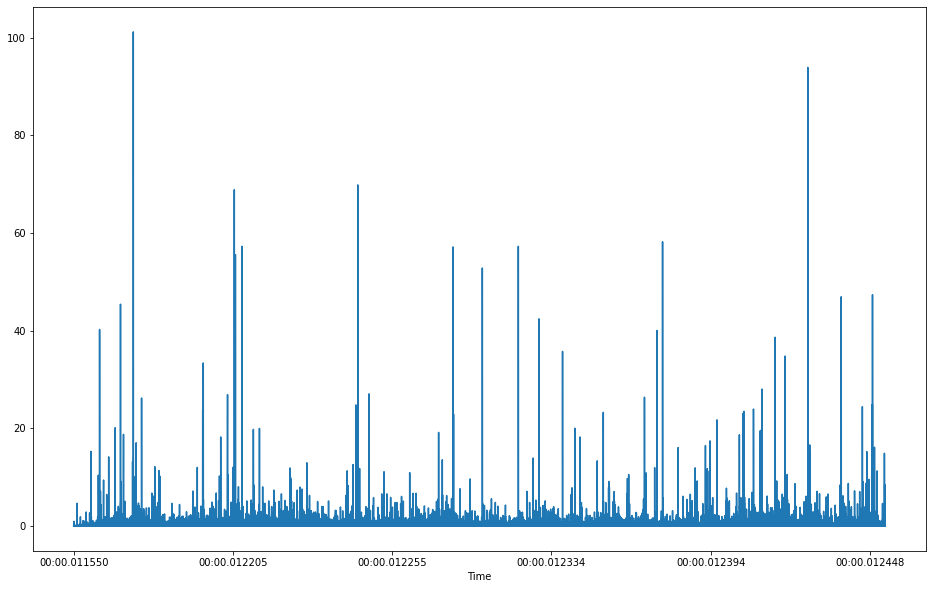

In [19]:
data['MEV'].plot(figsize=(16,10))

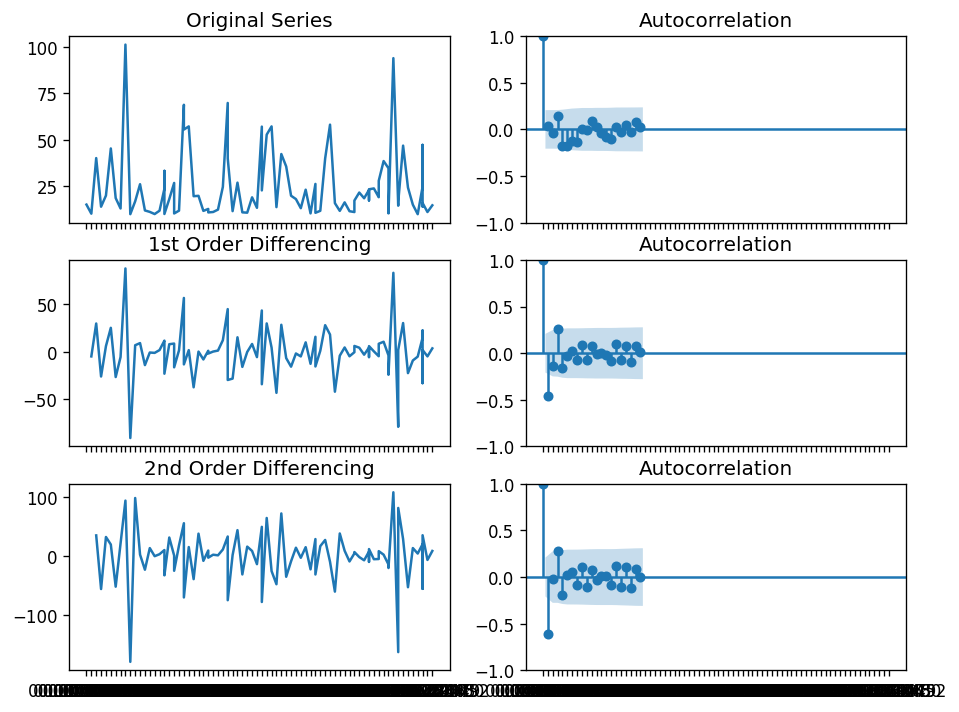

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# The new dataset is filtered for _____ with MEV values greater than 10ETH
df = data[data['MEV']>10]

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.MEV); axes[0, 0].set_title('Original Series')
plot_acf(df.MEV, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.MEV.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.MEV.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.MEV.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.MEV.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [21]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(df.MEV, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    MEV   No. Observations:                   90
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -386.400
Date:                Sun, 11 Sep 2022   AIC                            782.800
Time:                        23:58:25   BIC                            795.243
Sample:                             0   HQIC                           787.815
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9056      0.114     -7.958      0.000      -1.129      -0.683
ar.L2         -0.0167      0.115     -0.146      0.884      -0.242       0.208
ma.L1         -0.0002     10.752  -1.97e-05      1.0

/Users/macbook/opt/anaconda3/envs/virtual/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/opt/anaconda3/envs/virtual/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/opt/anaconda3/envs/virtual/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


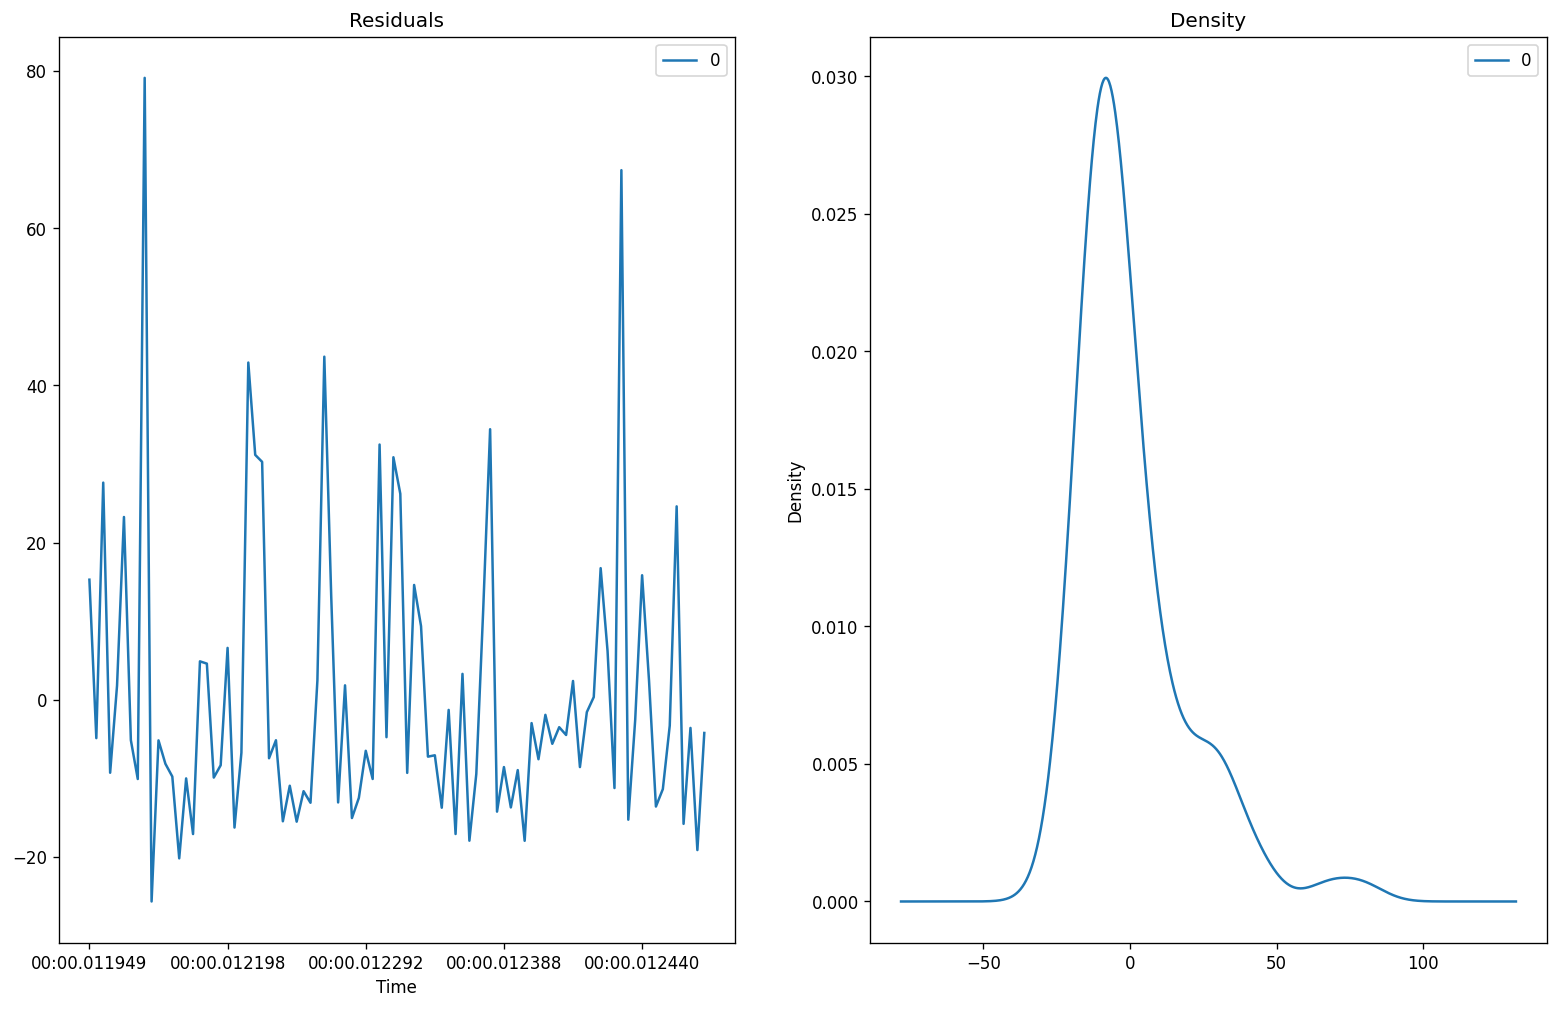

In [22]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0],figsize=(16,10))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

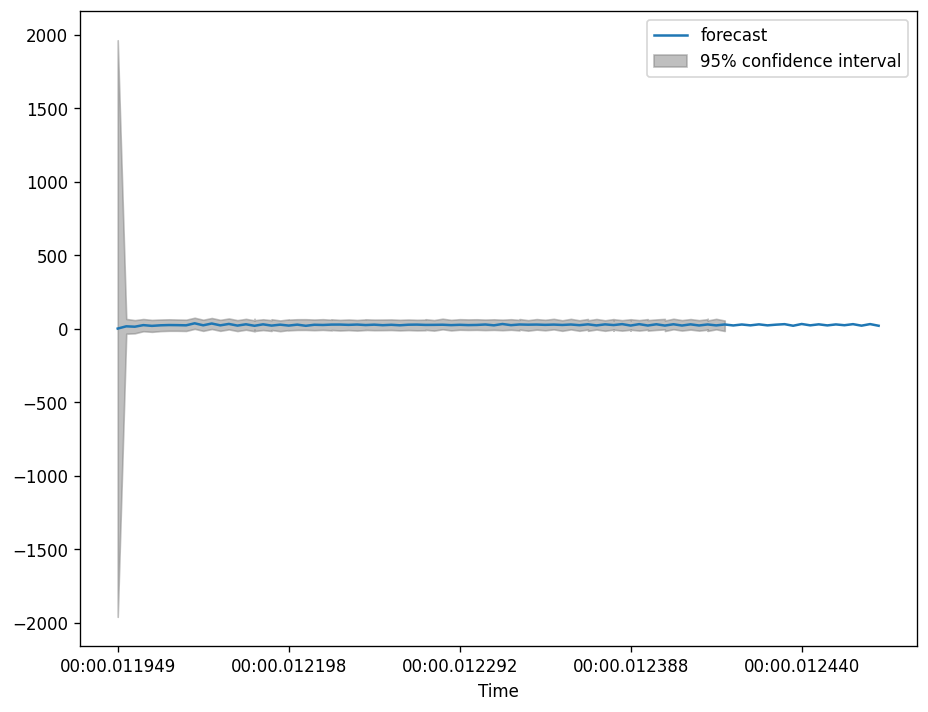

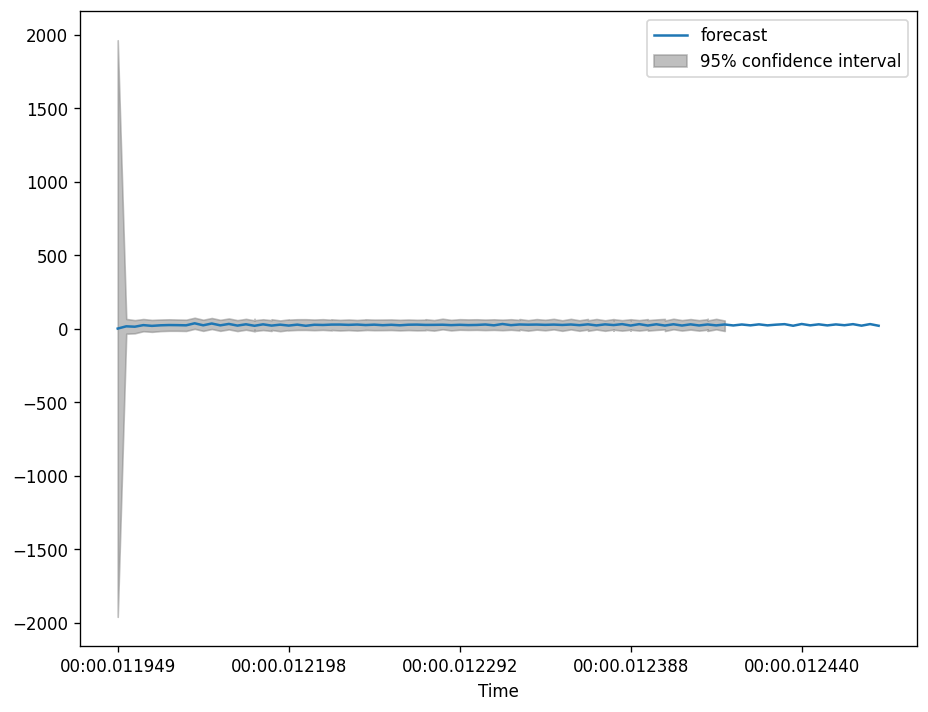

In [23]:
from statsmodels.graphics.tsaplots import plot_predict

# Plot components of forecast in detail
plot_predict(model_fit, dynamic=False, plot_insample=False)

In [24]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

stepwise_fit = auto_arima(df['MEV'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=789.158, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=782.907, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=784.800, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=784.787, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=875.679, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=786.818, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.271 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:                        SARIMAX   Log Likelihood                -389.454
Date:                Sun, 11 Sep 2022   AIC                            782.907
Time:                        23:58:26   BIC                            787.907
Sample:                             0   HQIC                           784.923
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.0357      3.220      7.776      0.000      18.725      31.346
sigma2       335.8439     47.896      7.012      0.000     241.969     429.719
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               120.41
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.97
Prob(H) (two-sided):                  0.19   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]

print(train.shape, test.shape)

(90, 12)
(60, 12) (30, 12)


In [26]:
model=sm.tsa.arima.ARIMA(train['MEV'], order=(1,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEV   No. Observations:                   60
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -259.529
Date:                Sun, 11 Sep 2022   AIC                            527.058
Time:                        23:58:26   BIC                            535.368
Sample:                             0   HQIC                           530.302
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8441      0.156     -5.428      0.000      -1.149      -0.539
ma.L1         -0.0273     17.148     -0.002      0.999     -33.637      33.582
ma.L2         -0.9721     16.659     -0.058      0.953     -33.624      31.680
sigma2       358.2254   6129.996      0.058      0.953   -1.17e+04    1.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                34.38
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             1.47
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
pred.index = test.index

<AxesSubplot:xlabel='Time'>

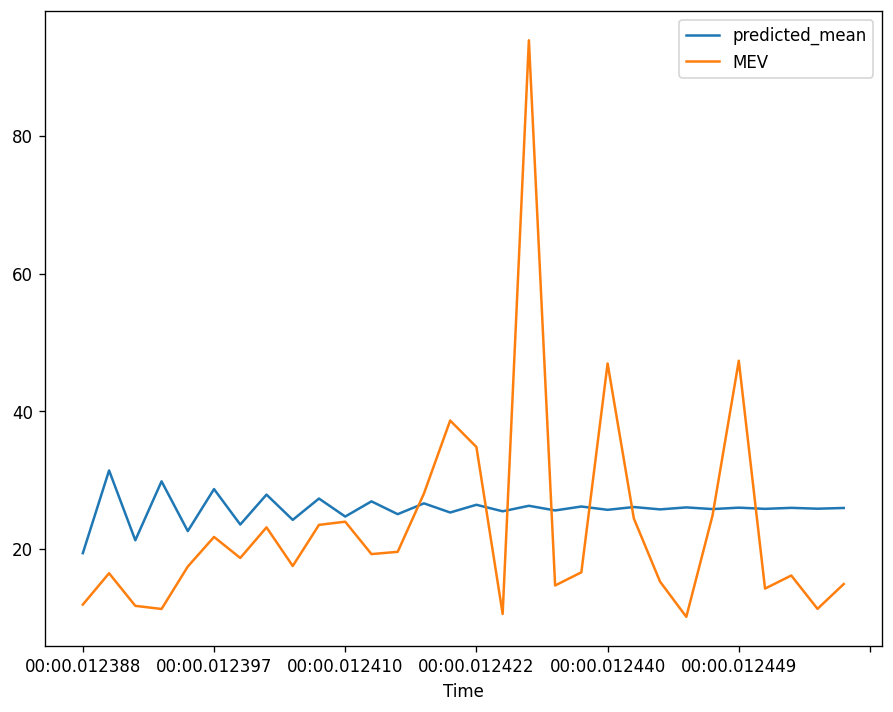

In [28]:
pred.plot(legend=True)
test['MEV'].plot(legend=True)

# 3

In [29]:
!pip install pystan

In [30]:
import pystan
import warnings

ModuleNotFoundError: No module named 'pystan'

In [ ]:
!pip install fbprophet==0.5 

In [ ]:
df2 = df['MEV']
df2['Time'] = pd.to_datetime(df['MEV'])
#df2 = df2.rename(columns={'Time':'ds', 'MEV':'mev'})

In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)
my_model.fit(df2)
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.head()

In [ ]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
my_model.plot(forecast, uncertainty=True)


In [ ]:
my_model.plot_components(forecast)

In [ ]:
fig1 = my_model.plot_components(forecast)


In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [ ]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [ ]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)